# Using AI to Predict Server Hard Drive Failure

Project by Samy Djemaï during the LOG6309E course at Polytechnique Montréal.

Inspired by [*Predicting Disk Replacement Towards Reliable Data Centers* (Botezatu et al., 2016)](https://www.kdd.org/kdd2016/papers/files/adf0849-botezatuA.pdf).

## Abstract

Server hardware failures can cause unexpected crashes and downtime, which should be avoided at all costs for companies. Hard disk drive (HDD) failure is one of such failures. This project aims at predicting upcoming hard drive failures, using SMART statistics provided by the drives themselves as a multivariate time-series fed into a neural network to warn server operators of necessary disk replacements.

## Dataset Analysis

We first need to assess the dataset we are using, to find out which values are meaningful in our analysis.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict


In [2]:
df = pd.read_csv("data/Q1_2020/2020-03-31.csv")
df


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2020-03-31,Z305B2QN,ST4000DM000,4000787030016,0,114.0,72273728.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-31,ZJV0XJQ4,ST12000NM0007,12000138625024,0,84.0,226044912.0,NaN,NaN,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-31,ZJV0XJQ3,ST12000NM0007,12000138625024,0,83.0,207232920.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-31,ZJV0XJQ0,ST12000NM0007,12000138625024,0,82.0,176197928.0,NaN,NaN,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-31,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,143.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132334,2020-03-31,ZA10MCEQ,ST8000DM002,8001563222016,0,68.0,6560712.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132335,2020-03-31,ZCH0CRTK,ST12000NM0007,12000138625024,0,82.0,176676744.0,NaN,NaN,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132336,2020-03-31,ZA13ZBCT,ST8000DM002,8001563222016,0,83.0,204034056.0,NaN,NaN,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132337,2020-03-31,PL1331LAHGD9NH,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,134.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset contains 63 SMART attributes.

In [3]:
df.isnull().sum().sort_values(ascending=False).head(72)


smart_255_raw           132339
smart_250_normalized    132339
smart_15_raw            132339
smart_15_normalized     132339
smart_13_raw            132339
                         ...  
smart_22_raw            118912
smart_183_normalized    112270
smart_183_raw           112270
smart_8_raw              94583
smart_8_normalized       94583
Length: 72, dtype: int64

Some SMART stats are not reported by any drive in the dataset. We can drop around 35 SMART attributes (= 70 columns) without losing too much information: when sorted in descending order, we remove all SMART attributes with more `NaN` values than `SMART_8`.


In [4]:
df1 = df.dropna(axis=1, thresh=int(0.2 * df.shape[0]))
df1


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_199_normalized,smart_199_raw,smart_200_normalized,smart_200_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
0,2020-03-31,Z305B2QN,ST4000DM000,4000787030016,0,114.0,72273728.0,NaN,NaN,91.0,...,200.0,0.0,NaN,NaN,100.0,37370.0,100.0,5.445219e+10,100.0,2.796870e+11
1,2020-03-31,ZJV0XJQ4,ST12000NM0007,12000138625024,0,84.0,226044912.0,NaN,NaN,89.0,...,200.0,0.0,100.0,0.0,100.0,13860.0,100.0,5.294202e+10,100.0,1.640811e+11
2,2020-03-31,ZJV0XJQ3,ST12000NM0007,12000138625024,0,83.0,207232920.0,NaN,NaN,98.0,...,200.0,0.0,100.0,0.0,100.0,11332.0,100.0,5.228804e+10,100.0,7.951115e+10
3,2020-03-31,ZJV0XJQ0,ST12000NM0007,12000138625024,0,82.0,176197928.0,NaN,NaN,93.0,...,200.0,0.0,100.0,0.0,100.0,15015.0,100.0,5.540053e+10,100.0,1.339848e+11
4,2020-03-31,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,143.0,...,200.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132334,2020-03-31,ZA10MCEQ,ST8000DM002,8001563222016,0,68.0,6560712.0,NaN,NaN,92.0,...,200.0,0.0,NaN,NaN,100.0,33084.0,100.0,8.139620e+10,100.0,1.917751e+11
132335,2020-03-31,ZCH0CRTK,ST12000NM0007,12000138625024,0,82.0,176676744.0,NaN,NaN,97.0,...,200.0,0.0,100.0,0.0,100.0,18576.0,100.0,6.776489e+10,100.0,1.413963e+11
132336,2020-03-31,ZA13ZBCT,ST8000DM002,8001563222016,0,83.0,204034056.0,NaN,NaN,89.0,...,200.0,0.0,NaN,NaN,100.0,29184.0,100.0,7.229272e+10,100.0,1.965452e+11
132337,2020-03-31,PL1331LAHGD9NH,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,134.0,100.0,100.0,...,200.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We now want to know which drives report the most SMART values.

In [5]:
df2 = df1.drop(df1.filter(like="normalized", axis=1).columns, axis=1)
df2.drop(labels=["date", "capacity_bytes"], axis=1, inplace=True)
df2


,serial_number,model,failure,smart_1_raw,smart_2_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_8_raw,...,smart_194_raw,smart_195_raw,smart_196_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_200_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,Z305B2QN,ST4000DM000,0,72273728.0,NaN,0.0,19.0,0.0,5.774153e+07,NaN,...,22.0,NaN,NaN,0.0,0.0,0.0,NaN,37370.0,5.445219e+10,2.796870e+11
1,ZJV0XJQ4,ST12000NM0007,0,226044912.0,NaN,0.0,9.0,0.0,7.462914e+08,NaN,...,27.0,226044912.0,NaN,0.0,0.0,0.0,0.0,13860.0,5.294202e+10,1.640811e+11
2,ZJV0XJQ3,ST12000NM0007,0,207232920.0,NaN,0.0,2.0,0.0,2.378736e+08,NaN,...,31.0,207232920.0,NaN,0.0,0.0,0.0,0.0,11332.0,5.228804e+10,7.951115e+10
3,ZJV0XJQ0,ST12000NM0007,0,176197928.0,NaN,0.0,6.0,0.0,7.546835e+08,NaN,...,24.0,176197928.0,NaN,0.0,0.0,0.0,0.0,15015.0,5.540053e+10,1.339848e+11
4,PL1331LAHG1S4H,HGST HMS5C4040ALE640,0,0.0,103.0,543.0,12.0,0.0,0.000000e+00,42.0,...,29.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132334,ZA10MCEQ,ST8000DM002,0,6560712.0,NaN,0.0,4.0,8.0,3.544600e+09,NaN,...,24.0,6560712.0,NaN,0.0,0.0,0.0,NaN,33084.0,8.139620e+10,1.917751e+11
132335,ZCH0CRTK,ST12000NM0007,0,176676744.0,NaN,0.0,3.0,0.0,4.197787e+08,NaN,...,22.0,176676744.0,NaN,0.0,0.0,0.0,0.0,18576.0,6.776489e+10,1.413963e+11
132336,ZA13ZBCT,ST8000DM002,0,204034056.0,NaN,0.0,6.0,0.0,3.351355e+09,NaN,...,33.0,204034056.0,NaN,0.0,0.0,0.0,NaN,29184.0,7.229272e+10,1.965452e+11
132337,PL1331LAHGD9NH,HGST HMS5C4040BLE640,0,0.0,100.0,459.0,7.0,0.0,0.000000e+00,42.0,...,33.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [6]:
df2.groupby(by="model").agg(lambda x: int(x.isnull().mean())).sum(axis=1).sort_values(
    ascending=True
)


model
ST10000NM0086                              3
ST6000DM001                                4
ST6000DM004                                4
ST6000DX000                                4
ST8000DM004                                4
ST8000DM005                                4
ST8000NM0055                               4
ST8000DM002                                4
ST500LM021                                 5
ST4000DM000                                5
ST4000DM005                                5
ST500LM030                                 5
ST12000NM0007                              6
ST12000NM0008                              6
ST16000NM001G                              7
WDC WD5000BPKT                             8
TOSHIBA MQ01ABF050M                        9
TOSHIBA MQ01ABF050                         9
TOSHIBA MG08ACA16TA                        9
TOSHIBA HDWE160                            9
TOSHIBA HDWF180                            9
ST500LM012 HN                              9
TOSH

In [20]:
df2.groupby(by="model").agg(lambda x: int(x.isnull().mean())).sum(axis=0).sort_values(
    ascending=False
)


smart_200_raw    34
smart_189_raw    32
smart_184_raw    32
smart_195_raw    32
smart_190_raw    29
smart_188_raw    29
smart_187_raw    29
smart_2_raw      25
smart_8_raw      25
smart_241_raw    22
smart_242_raw    22
smart_191_raw    21
smart_196_raw    21
smart_240_raw    20
smart_193_raw     8
smart_199_raw     6
smart_7_raw       6
smart_5_raw       6
smart_3_raw       6
smart_10_raw      6
smart_4_raw       6
smart_197_raw     6
smart_198_raw     6
smart_12_raw      1
smart_1_raw       1
smart_194_raw     1
smart_192_raw     1
smart_9_raw       1
failure           0
serial_number     0
dtype: int64

We can notice that Seagate drives report the most SMART parameters, followed by Western Digital, Toshiba and Hitachi drives. Seagate BarraCuda SSDs and DELLBOSS VD drives do not provide useful information.

In [7]:
df2.groupby(by="model").agg({"serial_number": "count"}).sort_values(
    by="serial_number", ascending=False
)


,serial_number
model,
ST12000NM0007,36997
ST4000DM000,19142
ST8000NM0055,14464
HGST HMS5C4040BLE640,12744
ST12000NM0008,10876
HGST HUH721212ALN604,10847
ST8000DM002,9793
TOSHIBA MG07ACA14TA,7200
HGST HMS5C4040ALE640,2896


The datacenter is mostly populated by Seagate drives, especially the ST12000NM0007 and ST4000DM000 models.

Now, let's take a look at the models which fail the most, in order to get a better set of failing drives. We will be using all data from Q1 2020.

In [8]:
failure_dict = defaultdict(lambda: [0, 0])
for filename in os.listdir("data/Q1_2020"):
    with open(f"data/Q1_2020/{filename}") as f:
        for line in f:
            line = line.rstrip()
            split_line = line.split(",")
            fail = split_line[4]
            if fail != "failure":
                failure_dict[split_line[2]][int(fail)] += 1

print(failure_dict)


defaultdict(<function <lambda> at 0x7fb114b523a0>, {'ST4000DM000': [1744529, 68], 'ST12000NM0007': [3368588, 126], 'HGST HMS5C4040ALE640': [260803, 4], 'ST8000NM0055': [1315654, 46], 'ST8000DM002': [891567, 18], 'HGST HMS5C4040BLE640': [1159683, 9], 'HGST HUH721212ALN604': [987616, 14], 'TOSHIBA MG07ACA14TA': [460212, 16], 'HGST HUH721212ALE600': [141934, 0], 'ST10000NM0086': [109196, 4], 'ST12000NM0008': [750681, 29], 'ST6000DX000': [80624, 1], 'TOSHIBA MQ01ABF050': [39102, 39], 'ST500LM030': [22677, 7], 'DELLBOSS VD': [5459, 0], 'TOSHIBA MQ01ABF050M': [37251, 9], 'WDC WD5000LPVX': [18736, 4], 'ST500LM012 HN': [43679, 13], 'HGST HUH728080ALE600': [91000, 0], 'TOSHIBA MD04ABA400V': [9009, 0], 'TOSHIBA HDWF180': [1820, 0], 'ST8000DM005': [2275, 0], 'ST4000DM005': [3549, 0], 'Seagate SSD': [9793, 0], 'Seagate BarraCuda SSD ZA250CM10002': [21684, 3], 'HGST HUH721010ALE600': [1820, 0], 'WDC WD5000LPCX': [4900, 1], 'HGST HDS5C4040ALE630': [2366, 0], 'ST16000NM001G': [5036, 0], 'ST500LM021':

In [16]:
failure_rate_dict = {k: [v[0], v[1], v[1] / v[0]] for k, v in failure_dict.items()}

failure_rate_df = (
    pd.DataFrame.from_dict(
        failure_rate_dict,
        orient="index",
        columns=["count", "fail_count", "failure_rate"],
    )
    .sort_values("failure_rate", ascending=False)
    .style.format({"failure_rate": "{:.4%}"})
)
failure_rate_df


,count,fail_count,failure_rate
ST8000DM004,209,1,0.4785%
TOSHIBA MQ01ABF050,39102,39,0.0997%
ST500LM030,22677,7,0.0309%
ST500LM012 HN,43679,13,0.0298%
TOSHIBA MQ01ABF050M,37251,9,0.0242%
WDC WD5000LPVX,18736,4,0.0213%
WDC WD5000LPCX,4900,1,0.0204%
Seagate BarraCuda SSD ZA250CM10002,21684,3,0.0138%
ST4000DM000,1744529,68,0.0039%
ST12000NM0008,750681,29,0.0039%


Upon analysis of the dataset, we can determine that two drives seem to be of interest:
- **Seagate ST4000DM000**
    - reports almost all SMART parameters
    - is one of the most used drives
    - has a high failure rate, which provides more failing individuals
- **Seagate ST12000NM0007**
    - reports slightly less SMART parameters
    - is the most used drive in the datacenter
    - has a similar failure rate

We will study the impact of various SMART parameters on the **Seagate ST4000DM000**, train the ML models on it and finally generalize to other drives, including the **Seagate ST12000NM0007**.

In [4]:
failed_st4000dm000_drives = set()

for filename in os.listdir("data/Q1_2020"):
    with open(f"data/Q1_2020/{filename}") as f:
        for line in f:
            line = line.rstrip()
            split_line = line.split(",")
            fail = split_line[4]
            if fail == "1" and split_line[2] == "ST4000DM000":
                failed_st4000dm000_drives.add(
                    (split_line[1], filename.replace(".csv", ""))
                )

print(failed_st4000dm000_drives)


{('S3010C0M', '2020-03-10'), ('Z304JDXX', '2020-01-02'), ('Z302T6HP', '2020-01-13'), ('Z304JKAE', '2020-01-08'), ('S300Z6PZ', '2020-01-15'), ('S300YQ0H', '2020-01-29'), ('Z305AQY2', '2020-03-12'), ('Z304G1P8', '2020-01-14'), ('Z304KBNT', '2020-01-20'), ('S301NH6F', '2020-02-07'), ('S301NXVE', '2020-02-14'), ('S301PTFQ', '2020-03-03'), ('S3010MAT', '2020-03-17'), ('Z3059Y23', '2020-03-29'), ('Z305GY0M', '2020-01-25'), ('Z302SXNQ', '2020-02-27'), ('Z305GVT3', '2020-03-12'), ('Z303RH74', '2020-03-16'), ('Z302RPCT', '2020-01-26'), ('Z305D66L', '2020-03-03'), ('Z302SZH2', '2020-03-06'), ('W300R7H5', '2020-01-25'), ('Z305D2DM', '2020-02-02'), ('Z302SZG8', '2020-01-12'), ('Z304HSB0', '2020-01-27'), ('Z302A12A', '2020-03-21'), ('Z305FDYS', '2020-01-17'), ('Z305ANWQ', '2020-02-06'), ('Z305D2WX', '2020-03-09'), ('Z304JPPZ', '2020-01-01'), ('Z303R4KK', '2020-02-16'), ('Z304K67H', '2020-03-18'), ('Z302SYN2', '2020-01-18'), ('Z304WG4J', '2020-01-25'), ('S300YQ5V', '2020-01-08'), ('Z302SZ3L', '2020-

## Case study: drive no. Z305AQY2

In [43]:
smart_dict = {}
with open("smart_titles") as f:
    for line in f:
        split_line = line.rstrip().split("\t")
        smart_dict[f"smart_{split_line[0]}_raw"] = split_line[1]

In [4]:
column_names = "date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_11_normalized,smart_11_raw,smart_12_normalized,smart_12_raw,smart_13_normalized,smart_13_raw,smart_15_normalized,smart_15_raw,smart_16_normalized,smart_16_raw,smart_17_normalized,smart_17_raw,smart_18_normalized,smart_18_raw,smart_22_normalized,smart_22_raw,smart_23_normalized,smart_23_raw,smart_24_normalized,smart_24_raw,smart_168_normalized,smart_168_raw,smart_170_normalized,smart_170_raw,smart_173_normalized,smart_173_raw,smart_174_normalized,smart_174_raw,smart_177_normalized,smart_177_raw,smart_179_normalized,smart_179_raw,smart_181_normalized,smart_181_raw,smart_182_normalized,smart_182_raw,smart_183_normalized,smart_183_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_189_normalized,smart_189_raw,smart_190_normalized,smart_190_raw,smart_191_normalized,smart_191_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_195_normalized,smart_195_raw,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_200_normalized,smart_200_raw,smart_201_normalized,smart_201_raw,smart_218_normalized,smart_218_raw,smart_220_normalized,smart_220_raw,smart_222_normalized,smart_222_raw,smart_223_normalized,smart_223_raw,smart_224_normalized,smart_224_raw,smart_225_normalized,smart_225_raw,smart_226_normalized,smart_226_raw,smart_231_normalized,smart_231_raw,smart_232_normalized,smart_232_raw,smart_233_normalized,smart_233_raw,smart_235_normalized,smart_235_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw"
column_names = column_names.split(",")

case_df = pd.DataFrame(columns=column_names)
for filename in os.listdir("data/Q1_2020"):
    with open(f"data/Q1_2020/{filename}") as f:
        for line in f:
            line = line.rstrip()
            split_line = line.split(",")
            if split_line[1] == "Z305AQY2":
                case_df.loc[len(case_df)] = split_line

In [5]:
case_df

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2020-01-01,Z305AQY2,ST4000DM000,4000787030016,0,108,16764696,,,99,...,,,,,,,,,,
1,2020-01-02,Z305AQY2,ST4000DM000,4000787030016,0,117,138177592,,,99,...,,,,,,,,,,
2,2020-01-03,Z305AQY2,ST4000DM000,4000787030016,0,117,129309520,,,99,...,,,,,,,,,,
3,2020-01-04,Z305AQY2,ST4000DM000,4000787030016,0,108,17993912,,,99,...,,,,,,,,,,
4,2020-01-05,Z305AQY2,ST4000DM000,4000787030016,0,117,151128664,,,99,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2020-03-11,Z305AQY2,ST4000DM000,4000787030016,0,114,64081336,,,98,...,,,,,,,,,,
68,2020-01-18,Z305AQY2,ST4000DM000,4000787030016,0,118,180687256,,,99,...,,,,,,,,,,
69,2020-02-05,Z305AQY2,ST4000DM000,4000787030016,0,111,32740712,,,99,...,,,,,,,,,,
70,2020-02-23,Z305AQY2,ST4000DM000,4000787030016,0,112,42780760,,,98,...,,,,,,,,,,


/tmp/ipykernel_12345/3104868200.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


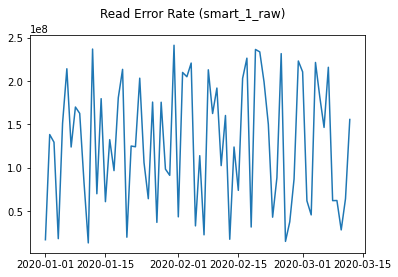

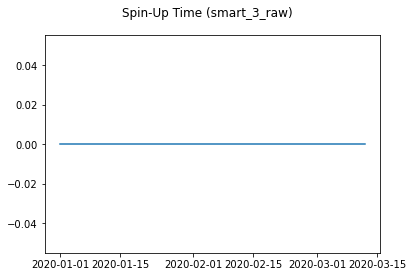

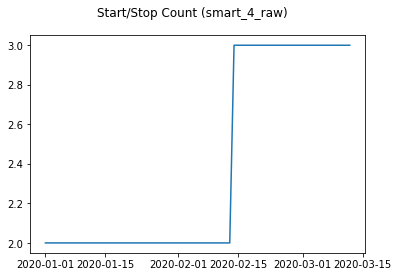

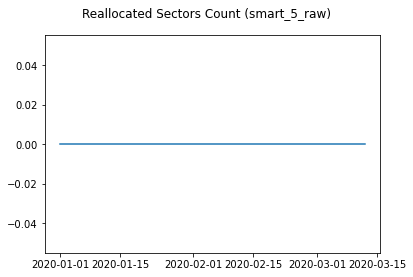

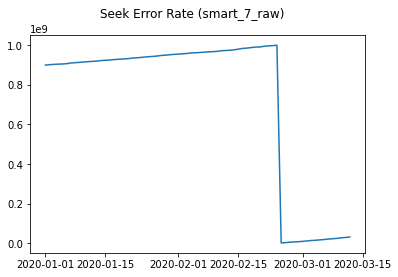

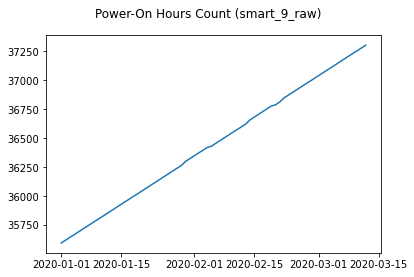

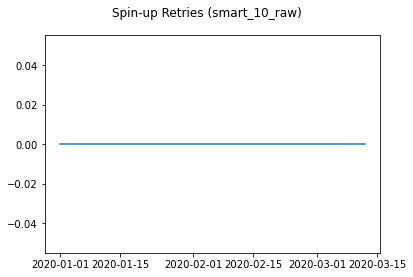

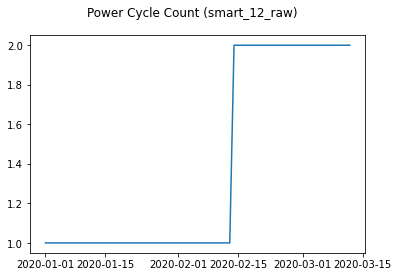

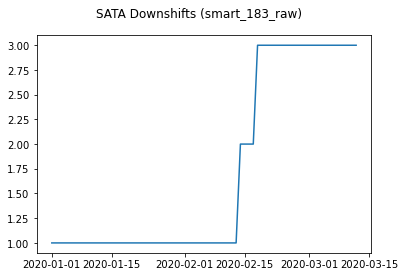

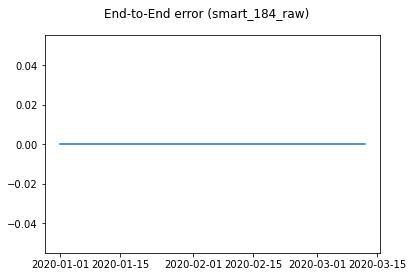

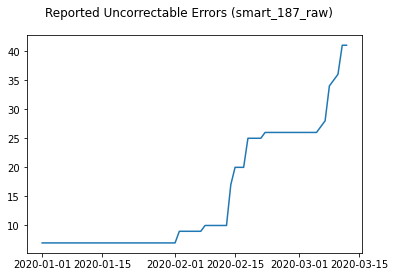

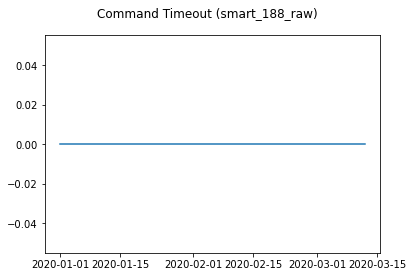

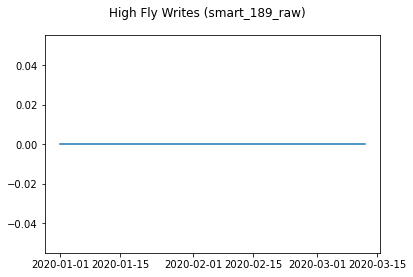

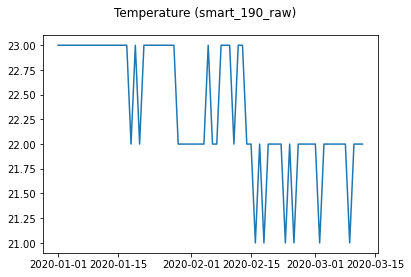

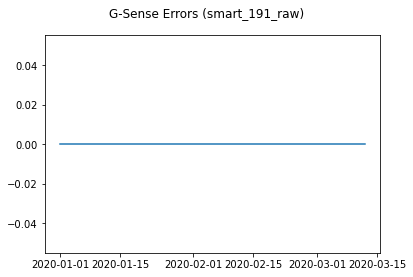

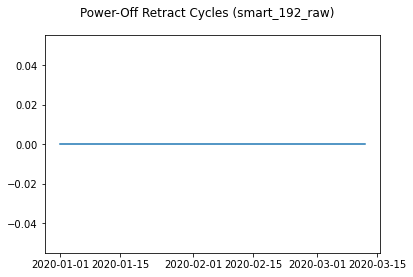

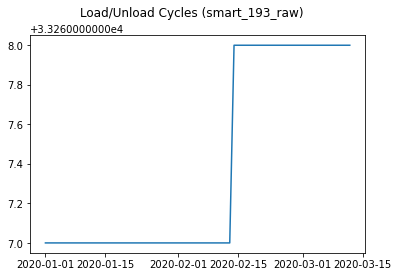

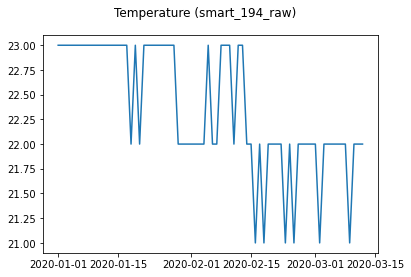

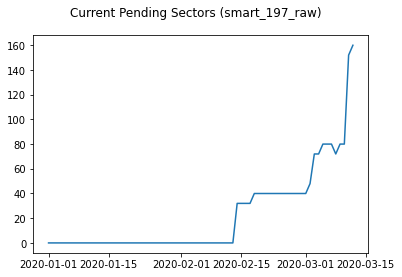

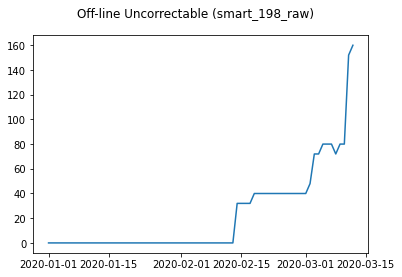

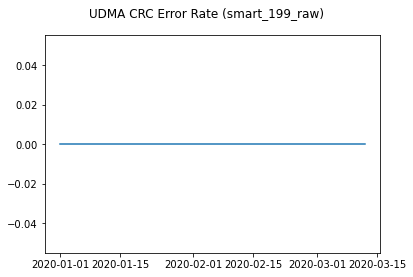

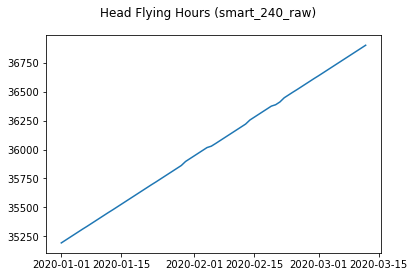

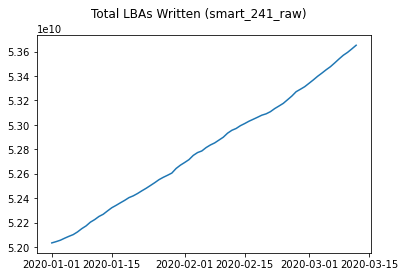

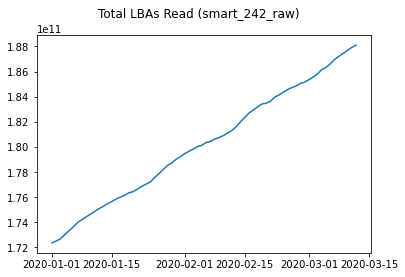

In [44]:
case_df2 = case_df.copy(deep=True)
case_df2.date = pd.to_datetime(case_df2['date'], format="%Y-%m-%d")
case_df2.set_index(['date'], inplace=True)
case_df2.sort_index(inplace=True)
case_df2.replace(r'^\s*$', np.nan, regex=True, inplace=True)
case_df2.dropna(axis=1, how='all', inplace=True)
case_df2.drop(case_df2.filter(like="normalized", axis=1).columns, axis=1, inplace=True)
case_df2.drop(['serial_number', 'model', 'capacity_bytes', 'failure'], axis=1, inplace=True)
case_df2 = case_df2.astype(float)
for col in case_df2.columns:
    fig = plt.figure()
    fig.suptitle(f"{smart_dict[col]} ({col})")
    plt.plot(case_df2[col])